In [1]:
import os
import re
import hashlib
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import GRU, LSTM, Masking, Dense, Flatten, MaxPooling2D, Conv2D, Dropout, BatchNormalization, Add, Activation, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import optimizers
from keras.utils import to_categorical, Sequence, plot_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.activations import relu, softmax
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train acc', 'Valid acc'], loc='lower right')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train loss', 'Valid loss'], loc='upper right')
  plt.show()



def multi_plot_loss(history_list):
  for i, h in enumerate(history_list):
    plt.plot(h.history['loss'], label=h.model.name, c=pl.cm.Dark2(i))
    plt.plot(h.history['val_loss'],'--', c=pl.cm.Dark2(i))

  plt.rcParams["figure.figsize"] = (15,9)
  plt.legend(loc='upper right')

  plt.show()


In [0]:
random.seed(123)

In [0]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'train', 'validation', or 'test'.
    """
    validation_percentage *= 100
    testing_percentage *= 100
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name.encode('utf-8')).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'test'
    else:
        result = 'train'
    return result

In [0]:
# function for extracting features from the entire dataset
def shuffle_in_unison(x, y, seed=None):
    assert len(x) == len(y)
    if seed is not None:
        np.random.seed(seed)
    p = np.random.permutation(len(x))
    return x[p], y[p]

def get_data(path: str, dataset: str, labels: list,
                 validation_size: float, test_size: float,
                 n_mfcc: int=13, hop_length: int=512, timeseries_length: int=64):
    if dataset not in ['train', 'test', 'validation']:
        raise RuntimeError("Select one of \'train\', \'test\', \'validation\'")

    x = []
    y = []
    if 'unknown' not in labels:
        labels.append('unknown')
    no_labels = len(labels)
    for root, dirs, files in os.walk(path):
        if len(files) > 0:
            label = root.split('\\')[-1]
            x += [Path(root) / file for file in files
                       if which_set(file, validation_size, test_size) == dataset]
            no = labels.index(label) if label in labels else labels.index('unknown')
            y += [no for file in files
                       if which_set(file, validation_size, test_size) == dataset]

    x = np.array(x)
    y = np.array(y)
    y = to_categorical(y)
    x, y = shuffle_in_unison(x, y, seed=1)

    #####
    # lets try to load all the data
    data = np.zeros((len(x), timeseries_length, n_mfcc+20))
    max_mfcc_length = 0

    print("Loading audio files...")
    for i, file in enumerate(x):
        print(f"\r{i}/{len(x)}", end='')
        file_path = x[i]
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(
            y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=audio, sr=sr, hop_length=hop_length
        )
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=audio, sr=sr, hop_length=hop_length
        )
        if len(mfcc) > max_mfcc_length:
            max_mfcc_length = len(mfcc)
        mfcc = mfcc.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), 0:n_mfcc] = mfcc
        data[i, 0:len(mfcc), n_mfcc:n_mfcc+1] = spectral_center.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), n_mfcc+1:n_mfcc+13] = chroma.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), n_mfcc+13:n_mfcc+20] = spectral_contrast.T[0:timeseries_length, :]
    
    #data = data[:, 0:max_mfcc_length, :]
    print(f"\r{len(x)}/{len(x)}")
    return data, y, max_mfcc_length

In [0]:
# Extract features from audio files
validation_size = 0.1
test_size = 0.1
labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']

#train_x, train_y, train_max_mfcc_length = get_data(Path('train/audio'), 'train',
#                            labels, validation_size, test_size)
#validation_x, validation_y, val_max_mfcc_length = get_data(Path('train/audio'), 'validation',
#                                      labels, validation_size, test_size)
#test_x, test_y, test_max_mfcc_length = get_data(Path('train/audio'), 'test',
#                          labels, validation_size, test_size)


In [0]:
## These np arrays need a lot of time to create so we'll save them in case something goes wrong.
#np.save(Path('train/train_x_13mfcc'), train_x)
#np.save(Path('train/train_y_13mfcc'), train_y)
#np.save(Path('train/validation_x_13mfcc'), validation_x)
#np.save(Path('train/validation_y_13mfcc'), validation_y)
#np.save(Path('train/test_x_13mfcc'), test_x)
#np.save(Path('train/test_y_13mfcc'), test_y)

In [0]:
prefix = '/gdrive/My Drive/data/keywords/'

In [0]:
# In case something goes wrong restore the data
train_x = np.load(Path(prefix+'train_x_13mfcc.npy'))
train_y = np.load(Path(prefix+'train_y_13mfcc.npy'))
validation_x = np.load(Path(prefix+'validation_x_13mfcc.npy'))
validation_y = np.load(Path(prefix+'validation_y_13mfcc.npy'))
test_x = np.load(Path(prefix+'test_x_13mfcc.npy'))
test_y = np.load(Path(prefix+'test_y_13mfcc.npy'))

In [10]:
test_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
# 'unknown' class is extremely unbalanced
_, counts = np.unique(train_y, return_counts=True, axis=0)
count = np.sum(train_y, axis=0)
class_weights = list(zip(range(len(counts)), reversed(counts)))
print(class_weights)

[(0, 1860), (1, 1853), (2, 1843), (3, 1842), (4, 1839), (5, 1852), (6, 1864), (7, 1839), (8, 1885), (9, 1861), (10, 32550), (11, 436)]


In [0]:
train_x.shape

(51088, 64, 33)

## RNN

In [0]:
def lfScheduleRNN1F(epoch, lr):
  if epoch > 14:
      return 0.0001
  if epoch > 7:
      return 0.001
  return 0.01

lfScheduleRNN1 = LearningRateScheduler(lfScheduleRNN1F, verbose=0)


In [0]:
def create_RNN(input_shape=(None, 33), cell_type='LSTM', recurrent_cells=[33, 128], dense_cells=[128], optimizer='adam', name=None):
    model = Sequential()
    RNNcell = LSTM if cell_type=='LSTM' else GRU
    
    for i, c in enumerate(recurrent_cells):
      if i==0:
        if len(recurrent_cells) == 1:
          model.add(RNNcell(c, return_sequences=False, input_shape=input_shape))
        else:
          model.add(RNNcell(c, return_sequences=True, input_shape=input_shape))
      elif i==len(recurrent_cells)-1:
        model.add(RNNcell(c, return_sequences=False))
      else:
        model.add(RNNcell(c, return_sequences=True))

    
    for c in dense_cells:
      model.add(Dense(c, activation='relu'))
    
    if name is not None:
      model.name=name
  
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
models = [
            create_RNN(input_shape=(None, 33), 
                       cell_type='LSTM', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128], 
                       optimizer='adam'),
          
            create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128], 
                       optimizer='adam')
]

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 41s 787us/step - loss: 1.4031 - accuracy: 0.6335 - val_loss: 1.3346 - val_accuracy: 0.6212
Epoch 2/60
51524/51524 [==============================] - 41s 794us/step - loss: 1.2492 - accuracy: 0.6382 - val_loss: 1.1986 - val_accuracy: 0.6255
Epoch 3/60
51524/51524 [==============================] - 41s 788us/step - loss: 1.1326 - accuracy: 0.6486 - val_loss: 1.0993 - val_accuracy: 0.6416
Epoch 4/60
51524/51524 [==============================] - 41s 787us/step - loss: 1.0278 - accuracy: 0.6743 - val_loss: 0.9845 - val_accuracy: 0.6796
Epoch 5/60
51524/51524 [==============================] - 41s 790us/step - loss: 0.9254 - accuracy: 0.6999 - val_loss: 0.8780 - val_accuracy: 0.7061
Epoch 6/60
51524/51524 [==============================] - 41s 795us/step - loss: 0.8314 - accuracy: 0.7275 - val_loss: 0.7951 - val_accuracy: 0.7360
Epoch 7/60
51524/51524 [==============================] -

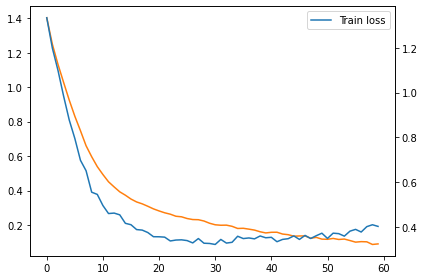

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 54s 1ms/step - loss: 1.6331 - accuracy: 0.6315 - val_loss: 1.5308 - val_accuracy: 0.6212
Epoch 2/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.4500 - accuracy: 0.6367 - val_loss: 1.4010 - val_accuracy: 0.6229
Epoch 3/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.3388 - accuracy: 0.6424 - val_loss: 1.2826 - val_accuracy: 0.6378
Epoch 4/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.2005 - accuracy: 0.6603 - val_loss: 1.1323 - val_accuracy: 0.6573
Epoch 5/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.0330 - accuracy: 0.6810 - val_loss: 0.9347 - val_accuracy: 0.6831
Epoch 6/60
51524/51524 [==============================] - 54s 1ms/step - loss: 0.8381 - accuracy: 0.7302 - val_loss: 0.7609 - val_accuracy: 0.7387
Epoch 7/60
51524/51524 [==============================] - 54s 1ms/ste

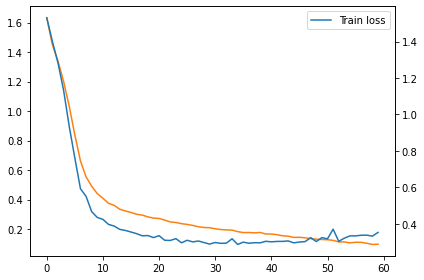

In [0]:
all_history = []

def lfScheduleRNN1F(epoch, lr):
  if epoch > 50:
      return 0.0001
  if epoch > 25:
      return 0.001
  return 0.01

lfScheduleRNN1 = LearningRateScheduler(lfScheduleRNN1F, verbose=0)


for model in models:
  history = model.fit(train_x, 
                      train_y, 
                      batch_size=512, 
                      epochs=60, 
                      class_weight=class_weights,
                      validation_data=(validation_x, validation_y))
  all_history.append(history)
  plot_loss(history)
                    
 

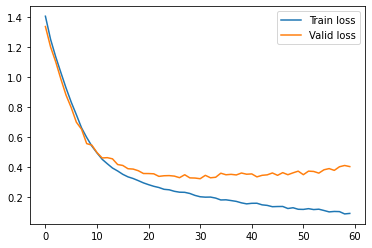

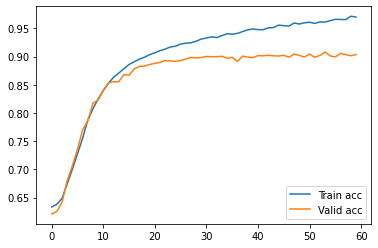

In [0]:
plot_loss(all_history[0])
plot_accuracy(all_history[0])

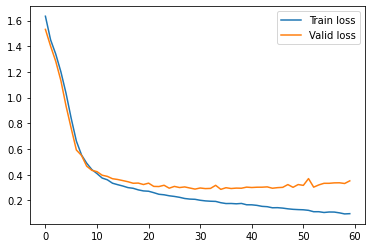

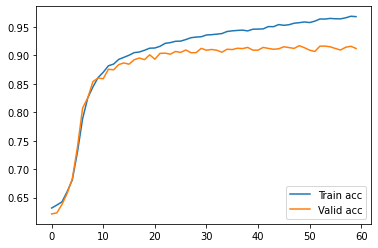

In [0]:
plot_loss(all_history[1])
plot_accuracy(all_history[1])

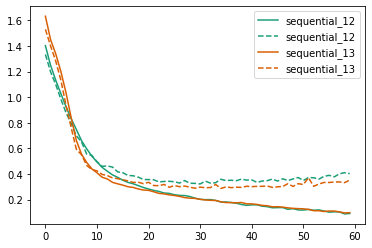

In [0]:
multi_plot_loss(all_history)

Train on 51524 samples, validate on 6842 samples
Epoch 1/30
51524/51524 [==============================] - 42s 822us/step - loss: 1.5699 - accuracy: 0.6282 - val_loss: 1.5418 - val_accuracy: 0.6169
Epoch 2/30
51524/51524 [==============================] - 41s 805us/step - loss: 1.3212 - accuracy: 0.6372 - val_loss: 1.2455 - val_accuracy: 0.6388
Epoch 3/30
51524/51524 [==============================] - 41s 799us/step - loss: 1.1631 - accuracy: 0.6501 - val_loss: 1.0961 - val_accuracy: 0.6538
Epoch 4/30
51524/51524 [==============================] - 42s 806us/step - loss: 1.0706 - accuracy: 0.6741 - val_loss: 1.0329 - val_accuracy: 0.6799
Epoch 5/30
51524/51524 [==============================] - 42s 823us/step - loss: 0.9933 - accuracy: 0.6926 - val_loss: 0.9284 - val_accuracy: 0.6986
Epoch 6/30
51524/51524 [==============================] - 42s 806us/step - loss: 0.9073 - accuracy: 0.7128 - val_loss: 0.8483 - val_accuracy: 0.7286
Epoch 7/30
51524/51524 [==============================] -

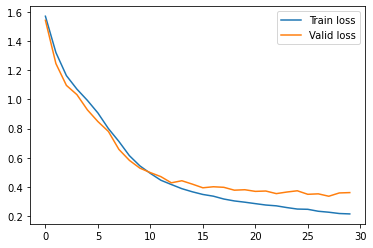

Train on 51524 samples, validate on 6842 samples
Epoch 1/30
51524/51524 [==============================] - 54s 1ms/step - loss: 1.6643 - accuracy: 0.6259 - val_loss: 1.5417 - val_accuracy: 0.6188
Epoch 2/30
51524/51524 [==============================] - 53s 1ms/step - loss: 1.4746 - accuracy: 0.6363 - val_loss: 1.4816 - val_accuracy: 0.6206
Epoch 3/30
51524/51524 [==============================] - 55s 1ms/step - loss: 1.4062 - accuracy: 0.6382 - val_loss: 1.3687 - val_accuracy: 0.6368
Epoch 4/30
51524/51524 [==============================] - 53s 1ms/step - loss: 1.2695 - accuracy: 0.6558 - val_loss: 1.2066 - val_accuracy: 0.6511
Epoch 5/30
51524/51524 [==============================] - 54s 1ms/step - loss: 1.1115 - accuracy: 0.6777 - val_loss: 1.0314 - val_accuracy: 0.6850
Epoch 6/30
51524/51524 [==============================] - 53s 1ms/step - loss: 0.9562 - accuracy: 0.7020 - val_loss: 0.8769 - val_accuracy: 0.7129
Epoch 7/30
51524/51524 [==============================] - 53s 1ms/ste

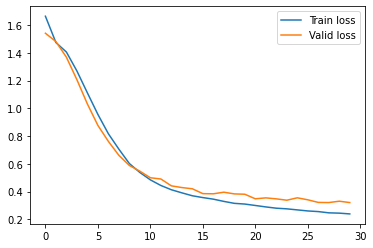

In [0]:
def lfScheduleRNN2F(epoch, lr):
  if epoch > 20:
    return 0.001
  return 0.01

lfScheduleRNN2 = LearningRateScheduler(lfScheduleRNN2F, verbose=0)

models = [
            create_RNN(input_shape=(None, 33), 
                       cell_type='LSTM', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128], 
                       optimizer='adam',
                       name='LSTM-basic'),
          
            create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128], 
                       optimizer='adam',
                       name='GRU-basic')
]



for model in models:
  history = model.fit(train_x, 
                      train_y, 
                      batch_size=512, 
                      epochs=30, 
                      class_weight=class_weights,
                      validation_data=(validation_x, validation_y))
  all_history.append(history)
  plot_loss(history)
                    

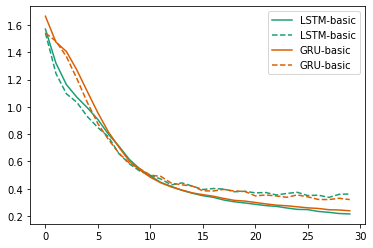

In [0]:
multi_plot_loss(all_history[2:])

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 28s 548us/step - loss: 1.7640 - accuracy: 0.6266 - val_loss: 1.5625 - val_accuracy: 0.6169
Epoch 2/60
51524/51524 [==============================] - 28s 541us/step - loss: 1.5178 - accuracy: 0.6322 - val_loss: 1.5532 - val_accuracy: 0.6196
Epoch 3/60
51524/51524 [==============================] - 27s 531us/step - loss: 1.4978 - accuracy: 0.6360 - val_loss: 1.5305 - val_accuracy: 0.6210
Epoch 4/60
51524/51524 [==============================] - 27s 527us/step - loss: 1.4739 - accuracy: 0.6367 - val_loss: 1.4933 - val_accuracy: 0.6212
Epoch 5/60
51524/51524 [==============================] - 28s 542us/step - loss: 1.4289 - accuracy: 0.6367 - val_loss: 1.4239 - val_accuracy: 0.6209
Epoch 6/60
51524/51524 [==============================] - 28s 537us/step - loss: 1.3831 - accuracy: 0.6369 - val_loss: 1.4071 - val_accuracy: 0.6212
Epoch 7/60
51524/51524 [==============================] -

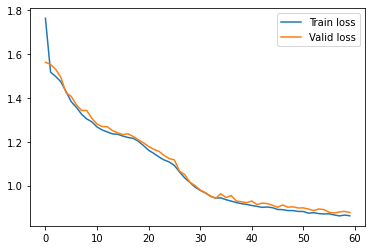

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 79s 2ms/step - loss: 1.6324 - accuracy: 0.6279 - val_loss: 1.5384 - val_accuracy: 0.6212
Epoch 2/60
51524/51524 [==============================] - 78s 2ms/step - loss: 1.4815 - accuracy: 0.6370 - val_loss: 1.4975 - val_accuracy: 0.6194
Epoch 3/60
51524/51524 [==============================] - 78s 2ms/step - loss: 1.4061 - accuracy: 0.6386 - val_loss: 1.3810 - val_accuracy: 0.6238
Epoch 4/60
51524/51524 [==============================] - 77s 1ms/step - loss: 1.3234 - accuracy: 0.6409 - val_loss: 1.3430 - val_accuracy: 0.6285
Epoch 5/60
51524/51524 [==============================] - 78s 2ms/step - loss: 1.2327 - accuracy: 0.6451 - val_loss: 1.1769 - val_accuracy: 0.6368
Epoch 6/60
51524/51524 [==============================] - 77s 1ms/step - loss: 1.0852 - accuracy: 0.6643 - val_loss: 1.0039 - val_accuracy: 0.6703
Epoch 7/60
51524/51524 [==============================] - 77s 1ms/ste

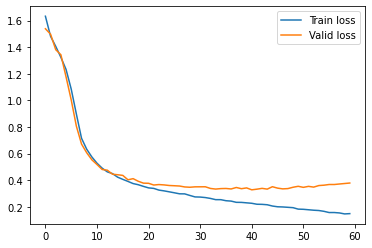

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 54s 1ms/step - loss: 1.6330 - accuracy: 0.6285 - val_loss: 1.5385 - val_accuracy: 0.6212
Epoch 2/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.4687 - accuracy: 0.6365 - val_loss: 1.4235 - val_accuracy: 0.6212
Epoch 3/60
51524/51524 [==============================] - 53s 1ms/step - loss: 1.3024 - accuracy: 0.6421 - val_loss: 1.2122 - val_accuracy: 0.6394
Epoch 4/60
51524/51524 [==============================] - 55s 1ms/step - loss: 1.0857 - accuracy: 0.6678 - val_loss: 0.9513 - val_accuracy: 0.6853
Epoch 5/60
51524/51524 [==============================] - 53s 1ms/step - loss: 0.8383 - accuracy: 0.7324 - val_loss: 0.7185 - val_accuracy: 0.7724
Epoch 6/60
51524/51524 [==============================] - 54s 1ms/step - loss: 0.6575 - accuracy: 0.7894 - val_loss: 0.5795 - val_accuracy: 0.8119
Epoch 7/60
51524/51524 [==============================] - 53s 1ms/ste

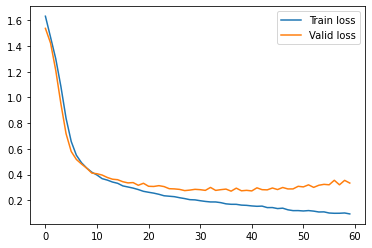

Train on 51524 samples, validate on 6842 samples
Epoch 1/60
51524/51524 [==============================] - 52s 1ms/step - loss: 2.0522 - accuracy: 0.6261 - val_loss: 1.6793 - val_accuracy: 0.6169
Epoch 2/60
51524/51524 [==============================] - 52s 1ms/step - loss: 1.5590 - accuracy: 0.6317 - val_loss: 1.5789 - val_accuracy: 0.6169
Epoch 3/60
51524/51524 [==============================] - 52s 1ms/step - loss: 1.5349 - accuracy: 0.6317 - val_loss: 1.5755 - val_accuracy: 0.6169
Epoch 4/60
51524/51524 [==============================] - 52s 1ms/step - loss: 1.5323 - accuracy: 0.6317 - val_loss: 1.5734 - val_accuracy: 0.6169
Epoch 5/60
51524/51524 [==============================] - 52s 1ms/step - loss: 1.5307 - accuracy: 0.6317 - val_loss: 1.5717 - val_accuracy: 0.6169
Epoch 6/60
51524/51524 [==============================] - 52s 1ms/step - loss: 1.5297 - accuracy: 0.6317 - val_loss: 1.5706 - val_accuracy: 0.6169
Epoch 7/60
51524/51524 [==============================] - 52s 1ms/ste

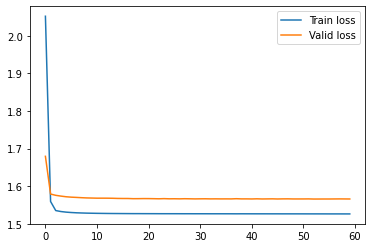

In [0]:
models = [
            create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33], 
                       dense_cells=[128], 
                       optimizer='adam',
                       name='GRU-single'),
          
            create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33, 33, 128], 
                       dense_cells=[128], 
                       optimizer='adam',
                       name='GRU-triple'),
          
            create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128, 64], 
                       optimizer='adam',
                       name='GRU-dense'),
          
           create_RNN(input_shape=(None, 33), 
                       cell_type='GRU', 
                       recurrent_cells=[33, 128], 
                       dense_cells=[128], 
                       optimizer='sgd',
                       name='GRU-sgd'),
]

for model in models:
  history = model.fit(train_x, 
                      train_y, 
                      batch_size=512, 
                      epochs=60, 
                      class_weight=class_weights,
                      validation_data=(validation_x, validation_y))
  all_history.append(history)
  plot_loss(history)
                    

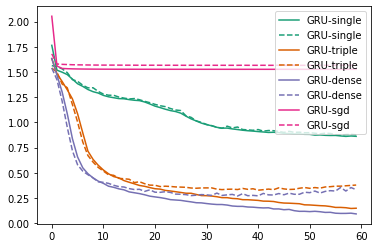

In [0]:
multi_plot_loss(all_history[5:])

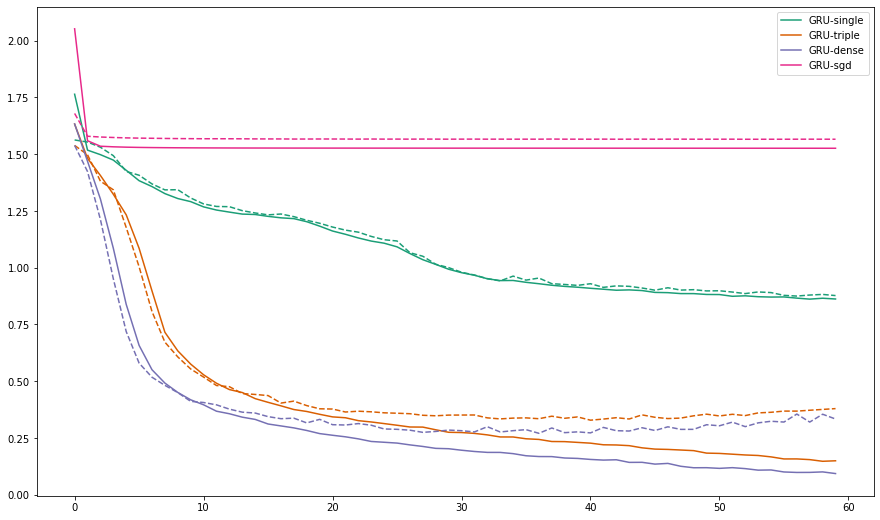

In [0]:
multi_plot_loss(all_history[5:])

In [0]:
history.history['val_accuracy'][-1]

0.6169248819351196

In [0]:
N=4

acc = np.zeros((N,1))
for i in range(N):
    model = create_RNN(input_shape=(None, 33), 
                    cell_type='GRU', 
                    recurrent_cells=[33, 128], 
                    dense_cells=[128, 64], 
                    optimizer='adam',
                    name='GRU-dense')
    history = model.fit(train_x, 
                      train_y, 
                      batch_size=512, 
                      epochs=25, 
                      class_weight=class_weights,
                      validation_data=(validation_x, validation_y))

    acc[i] = history.history['val_accuracy'][-1]
    print(acc)
print(acc)
print(acc.mean(axis=0), acc.std(axis=0))

Train on 51524 samples, validate on 6842 samples
Epoch 1/25
51524/51524 [==============================] - 41s 791us/step - loss: 1.6779 - accuracy: 0.6270 - val_loss: 1.5414 - val_accuracy: 0.6209
Epoch 2/25
51524/51524 [==============================] - 40s 772us/step - loss: 1.4650 - accuracy: 0.6370 - val_loss: 1.4723 - val_accuracy: 0.6212
Epoch 3/25
51524/51524 [==============================] - 40s 769us/step - loss: 1.3966 - accuracy: 0.6370 - val_loss: 1.3904 - val_accuracy: 0.6212
Epoch 4/25
51524/51524 [==============================] - 39s 761us/step - loss: 1.2966 - accuracy: 0.6370 - val_loss: 1.3038 - val_accuracy: 0.6215
Epoch 5/25
51524/51524 [==============================] - 39s 765us/step - loss: 1.2058 - accuracy: 0.6372 - val_loss: 1.1721 - val_accuracy: 0.6217
Epoch 6/25
51524/51524 [==============================] - 40s 785us/step - loss: 1.0342 - accuracy: 0.6734 - val_loss: 0.9092 - val_accuracy: 0.7055
Epoch 7/25
51524/51524 [==============================] -

## ResNets

In [12]:
train_X_norm = train_x - train_x.mean(axis=0)
train_X_norm_std = np.std(train_X_norm)
train_X_norm = train_X_norm / train_X_norm_std
train_X_norm = train_X_norm.reshape(train_X_norm.shape + (1,))

valid_X_norm = validation_x - train_x.mean(axis=0)
valid_X_norm = valid_X_norm / train_X_norm_std
valid_X_norm = valid_X_norm.reshape(valid_X_norm.shape + (1,))

print(np.std(valid_X_norm), np.mean(valid_X_norm), valid_X_norm.shape)

0.984886727039458 -0.0028306358914072963 (6842, 64, 33, 1)


In [0]:
test_X_norm = test_x - train_x.mean(axis=0)
test_X_norm = test_X_norm / train_X_norm_std
test_X_norm = test_X_norm.reshape(test_X_norm.shape + (1,))


In [0]:
def lfScheduleResNetF(epoch, lr):
  if epoch > 14:
      return 0.0001
  if epoch > 7:
      return 0.001
  return 0.01

lrschedulerResNet1 = LearningRateScheduler(lfScheduleResNetF, verbose=0)


In [0]:
def ResidLayer(input, filters, strides=(1,1), n=3, bm=0.99, l2val=1e-4):
    X = Conv2D(filters,
               (3,3), 
               strides=strides, 
               padding="same", 
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(input)
    X = BatchNormalization(momentum=bm)(X)
    X = Activation('relu')(X)

    if strides != (1,1):
        shortcut = Conv2D(filters, 
                          (1,1), 
                          strides=(2,2), 
                          padding="same",
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(l2val))(input)
        shortcut = BatchNormalization(momentum=bm)(shortcut)

    for _ in range(n-2):
        X = Conv2D(filters, 
                   (3,3), strides=(1,1), 
                   padding="same",
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(l2val))(X)
        X = BatchNormalization(momentum=bm)(X)
        X = Activation('relu')(X)

    X = Conv2D(filters, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X)
    X = BatchNormalization(momentum=bm)(X)

    #if strides != (1,1):
    #    input = ZeroPadding2D(padding=strides)
    if strides != (1,1):
      X = Add()([X, shortcut])
    else:
      X = Add()([X, input])
    output = Activation('relu')(X)
    return output



In [0]:
def ResNet(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(16, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X, name='ResNet')


In [0]:
resnet1 = np.array([
  0.9582,
  0.9558608531951904,
  0.957468569278717])
(resnet1.mean(), resnet1.std())

(0.9571764741579692, 0.0009770334737651176)

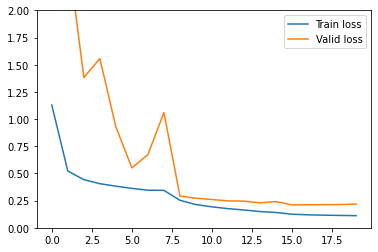

In [0]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train loss', 'Valid loss'], loc='upper right')
  plt.ylim(0, 2)
  plt.show()

In [0]:
all_history.append(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Train on 51524 samples, validate on 6842 samples
Epoch 1/20
51524/51524 [==============================] - 113s 2ms/step - loss: 1.0240 - accuracy: 0.7500 - val_loss: 2.6222 - val_accuracy: 0.5512
Epoch 2/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.5317 - accuracy: 0.8955 - val_loss: 1.2023 - val_accuracy: 0.7173
Epoch 3/20
51524/51524 [==============================] - 106s 2ms/step - loss: 0.4531 - accuracy: 0.9181 - val_loss: 0.8413 - val_accuracy: 0.8044
Epoch 4/20
51524/51524 [==============================] - 106s 2ms/step - loss: 0.4182 - accuracy: 0.9248 - val_loss: 0.6139 - val_accuracy: 0.8622
Epoch 5/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.3952 - accuracy: 0.9307 - val_loss: 0.7121 - val_accuracy: 0.8309
Epoch 6/20
51524/51524 [==============================] - 108s 2ms/step - loss: 0.3703 - accuracy: 0.9364 - val_loss: 0.5897 - val_accuracy: 0.8585
Epoch 7/20
51524/51524 [==============================] - 107s 

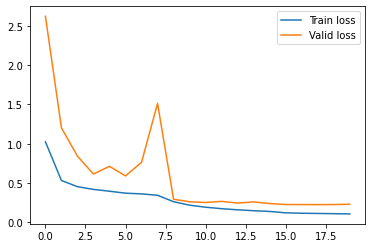

Train on 51524 samples, validate on 6842 samples
Epoch 1/20
51524/51524 [==============================] - 113s 2ms/step - loss: 1.0354 - accuracy: 0.7456 - val_loss: 6.8793 - val_accuracy: 0.6562
Epoch 2/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.5452 - accuracy: 0.8889 - val_loss: 0.8869 - val_accuracy: 0.7938
Epoch 3/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.4602 - accuracy: 0.9150 - val_loss: 0.6347 - val_accuracy: 0.8549
Epoch 4/20
47360/51524 [==========================>...] - ETA: 8s - loss: 0.4141 - accuracy: 0.9247

In [0]:
N=3
acc = np.zeros((N,1))

for i in range(N):
    resnet20 = ResNet(input_shape=(train_x.shape[1],train_x.shape[2],1),classes=len(labels))
    resnet20.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = resnet20.fit(train_X_norm, 
                        train_y, 
                        batch_size=128, 
                        epochs=20, 
                        class_weight=class_weights,
                        validation_data=(valid_X_norm, validation_y),
                        callbacks=[lrschedulerResNet1]
                        )
    all_history.append(history)
    plot_loss(history)
    acc[i+1] = history.history['val_accuracy'][-1]
print(acc)
print(acc.mean(axis=0), acc.std(axis=0))


In [0]:
def lfScheduleResNetDropoutF(epoch, lr):
  if epoch > 14:
      return 0.0001
  if epoch > 7:
      return 0.001
  return 0.01

lrschedulerResNetDropout = LearningRateScheduler(lfScheduleResNetDropoutF, verbose=0)


In [0]:
def ResNetDropout(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(16, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = Dropout(0.2)(X)
    X = ResidLayer(X, 64, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = Dropout(0.2)(X)
    X = ResidLayer(X, 64, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Dense(100, activation=relu)(X)
    X = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X, name='ResNetDropout')


In [0]:
resnetDropout = ResNetDropout(input_shape=(train_x.shape[1],train_x.shape[2],1),classes=len(labels))
resnetDropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = resnetDropout.fit(train_X_norm, 
                    train_y, 
                    batch_size=400, 
                    epochs=20, 
                    class_weight=class_weights,
                    validation_data=(valid_X_norm, validation_y),
                    callbacks=[lrschedulerResNetDropout]
                    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNetDropout", outputs=Tensor("de...)`


Train on 51088 samples, validate on 6798 samples
Epoch 1/20
51088/51088 [==============================] - 96s 2ms/step - loss: 3503.6024 - accuracy: 0.5740 - val_loss: 184.3068 - val_accuracy: 0.0362
Epoch 2/20
51088/51088 [==============================] - 91s 2ms/step - loss: 2349.0337 - accuracy: 0.6587 - val_loss: 6.1625 - val_accuracy: 0.2155
Epoch 3/20
51088/51088 [==============================] - 91s 2ms/step - loss: 1499.3260 - accuracy: 0.7528 - val_loss: 3.1976 - val_accuracy: 0.3607
Epoch 4/20
51088/51088 [==============================] - 91s 2ms/step - loss: 909.0301 - accuracy: 0.8571 - val_loss: 2.6837 - val_accuracy: 0.6041
Epoch 5/20
51088/51088 [==============================] - 91s 2ms/step - loss: 668.0483 - accuracy: 0.8961 - val_loss: 8.7653 - val_accuracy: 0.5806
Epoch 6/20
51088/51088 [==============================] - 91s 2ms/step - loss: 614.1794 - accuracy: 0.9077 - val_loss: 4.7183 - val_accuracy: 0.6177
Epoch 7/20
51088/51088 [============================

In [0]:
def lfScheduleResNet15F(epoch, lr):
  if epoch > 15:
      return 0.01
  return 0.1
lrschedulerResNet15 = LearningRateScheduler(lfScheduleResNet15F, verbose=0)


In [0]:
def ResidLayer15(input, filters, l, n=3, bm=0.99, l2val=1e-4):
    X = Conv2D(filters,
               (3,3), 
               strides=(1,1), 
               padding="same", 
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val),
               dilation_rate=(int(2**(l//3)), (int(2**(l//3)))),
               use_bias=True)(input)
    X = Activation('relu')(X)
    X = BatchNormalization(momentum=bm)(X)

    X = Conv2D(filters, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val),
               dilation_rate=(int(2**((1+l)//3)), (int(2**((1+l)//3)))),
               use_bias=True)(X)
    X = Activation('relu')(X)
    X = BatchNormalization(momentum=bm)(X)

    X = Add()([X, input])
    return X



In [0]:
def ResNet15(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(45, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val),
               dilation_rate=(1,1),
               use_bias=True)(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer15(X, 45, 2, n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer15(X, 45, 4, n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer15(X, 45, 6, n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer15(X, 45, 8, n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer15(X, 45, 10, n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer15(X, 45, 12, n=n, bm=batchnorm_momentum,l2val=l2val)
  
    X = Conv2D(45, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val),
               dilation_rate=(16,16),
               use_bias=True)(X)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X_output = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X_output, name='ResNetDropout')


In [0]:
ResNet15(input_shape=(train_x.shape[1],train_x.shape[2],1),classes=len(labels), l2val=1e-5).summary()

Model: "ResNetDropout"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 33, 1)    0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 33, 45)   450         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 64, 33, 45)   180         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 64, 33, 45)   0           batch_normalization_45[0][0]     
______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNetDropout", outputs=Tensor("de...)`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNetDropout", outputs=Tensor("de...)`


Train on 51524 samples, validate on 6842 samples
Epoch 1/20
51524/51524 [==============================] - 166s 3ms/step - loss: 1.4510 - accuracy: 0.6264 - val_loss: 1.3667 - val_accuracy: 0.6254
Epoch 2/20
51524/51524 [==============================] - 162s 3ms/step - loss: 1.2115 - accuracy: 0.6481 - val_loss: 1.9578 - val_accuracy: 0.6166
Epoch 3/20
51524/51524 [==============================] - 162s 3ms/step - loss: 0.9250 - accuracy: 0.7113 - val_loss: 2.1989 - val_accuracy: 0.4901
Epoch 4/20
51524/51524 [==============================] - 162s 3ms/step - loss: 0.6240 - accuracy: 0.8061 - val_loss: 1.5793 - val_accuracy: 0.4579
Epoch 5/20
51524/51524 [==============================] - 162s 3ms/step - loss: 0.4195 - accuracy: 0.8717 - val_loss: 1.3679 - val_accuracy: 0.6568
Epoch 6/20
51524/51524 [==============================] - 162s 3ms/step - loss: 0.3073 - accuracy: 0.9111 - val_loss: 0.6724 - val_accuracy: 0.7957
Epoch 7/20
51524/51524 [==============================] - 162s 

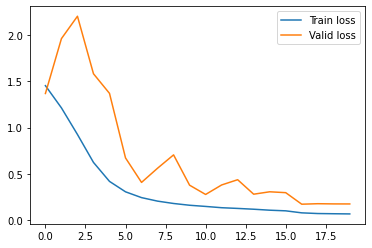

Train on 51524 samples, validate on 6842 samples
Epoch 1/20
51524/51524 [==============================] - 165s 3ms/step - loss: 1.4530 - accuracy: 0.6273 - val_loss: 1.3869 - val_accuracy: 0.6269
Epoch 2/20
51524/51524 [==============================] - 162s 3ms/step - loss: 1.2279 - accuracy: 0.6475 - val_loss: 1.8742 - val_accuracy: 0.4215
Epoch 3/20
20992/51524 [===========>..................] - ETA: 1:32 - loss: 1.0739 - accuracy: 0.6766

In [0]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
N=3

acc = np.zeros((N,1))
for i in range(N):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=0.001)


    resnet15 = ResNet15(input_shape=(train_x.shape[1],train_x.shape[2],1),classes=len(labels), l2val=1e-5)
    opt15 = optimizers.SGD(learning_rate=0.1)
    resnet15.compile(optimizer=opt15, loss='categorical_crossentropy', metrics=['accuracy'])
    history = resnet15.fit(train_X_norm, 
                        train_y, 
                        batch_size=256, 
                        epochs=20, 
                        validation_data=(valid_X_norm, validation_y),
                        class_weight=class_weights,
                        callbacks=[reduce_lr]
                        )
    acc[i] = history.history['val_accuracy'][-1]
    print(acc)
    plot_loss(history)
print(acc)
print(acc.mean(axis=0), acc.std(axis=0))

In [0]:
0.94855303

In [16]:
resnet20 = ResNet(input_shape=(train_x.shape[1],train_x.shape[2],1),classes=len(labels))
resnet20.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = resnet20.fit(train_X_norm, 
                        train_y, 
                        batch_size=128, 
                        epochs=20, 
                        class_weight=class_weights,
                        validation_data=(valid_X_norm, validation_y),
                        callbacks=[lrschedulerResNet1]
                        )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Train on 51524 samples, validate on 6842 samples
Epoch 1/20
51524/51524 [==============================] - 118s 2ms/step - loss: 1.0439 - accuracy: 0.7431 - val_loss: 14.6757 - val_accuracy: 0.0697
Epoch 2/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.5344 - accuracy: 0.8945 - val_loss: 1.0028 - val_accuracy: 0.7483
Epoch 3/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.4496 - accuracy: 0.9200 - val_loss: 1.0302 - val_accuracy: 0.7631
Epoch 4/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.4092 - accuracy: 0.9286 - val_loss: 0.7470 - val_accuracy: 0.8077
Epoch 5/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.3884 - accuracy: 0.9316 - val_loss: 0.5517 - val_accuracy: 0.8756
Epoch 6/20
51524/51524 [==============================] - 107s 2ms/step - loss: 0.3705 - accuracy: 0.9360 - val_loss: 0.4790 - val_accuracy: 0.8970
Epoch 7/20
51524/51524 [==============================] - 107s

In [18]:
resnet20.evaluate(x=test_X_norm, y=test_y, batch_size=64)

6896/6896 [==============================] - 5s 752us/step


[0.2236459396278222, 0.9601218104362488]

In [0]:
def get_confusion_matrix(x, y, model, no_labels=12):
    assert x.shape[0] == y.shape[0]
    if y.shape[1] != 1: # 0-9 encoding
        y = np.argmax(y, axis=1)
    else:
        y = y.flatten() # one-hot encoding
    confusion_matrix = np.zeros((no_labels, no_labels)).astype(int)
    pred = np.argmax(model.predict(x), axis=1)
    for i in range(pred.shape[0]):
        confusion_matrix[pred[i], y[i]] += 1
    return confusion_matrix



In [0]:
cm = get_confusion_matrix(test_X_norm, test_y, resnet20, no_labels=12)


array([[ 244,    0,    0,    1,    1,    0,    0,    0,    0,    0,    0,
           0],
       [   0,  221,    0,    7,    0,    0,    1,    0,    0,    3,    5,
           0],
       [   1,    2,  251,    0,    0,    0,    0,    2,    3,    2,    8,
           0],
       [   0,    6,    0,  216,    0,    0,    0,    0,    0,    1,    5,
           0],
       [   1,    0,    0,    0,  254,    0,    0,    1,    0,    0,    7,
           0],
       [   0,    0,    0,    0,    1,  232,    0,    0,    0,    0,    9,
           0],
       [   0,    0,    0,    1,    0,    0,  229,    1,    0,    0,    7,
           0],
       [   0,    0,    5,    0,    0,    0,    1,  246,    0,    3,    3,
           0],
       [   0,    0,    1,    0,    0,    0,    0,    0,  236,    1,    4,
           0],
       [   0,    8,    1,    8,    0,    0,    0,    0,    0,  228,   16,
           0],
       [  10,   15,   14,   20,   11,   27,   15,   12,   10,   13, 4204,
           1],
       [   0,    0,  

In [0]:
from tabulate import tabulate

In [0]:
table = tabulate(cm, headers=labels, tablefmt="fancy_grid")

In [32]:
print(table)

╒═══════╤══════╤══════╤════════╤════════╤═════════╤══════╤═══════╤════════╤══════╤═══════════╤═══════════╕
│   yes │   no │   up │   down │   left │   right │   on │   off │   stop │   go │   unknown │   silence │
╞═══════╪══════╪══════╪════════╪════════╪═════════╪══════╪═══════╪════════╪══════╪═══════════╪═══════════╡
│   244 │    0 │    0 │      1 │      1 │       0 │    0 │     0 │      0 │    0 │         0 │         0 │
├───────┼──────┼──────┼────────┼────────┼─────────┼──────┼───────┼────────┼──────┼───────────┼───────────┤
│     0 │  221 │    0 │      7 │      0 │       0 │    1 │     0 │      0 │    3 │         5 │         0 │
├───────┼──────┼──────┼────────┼────────┼─────────┼──────┼───────┼────────┼──────┼───────────┼───────────┤
│     1 │    2 │  251 │      0 │      0 │       0 │    0 │     2 │      3 │    2 │         8 │         0 │
├───────┼──────┼──────┼────────┼────────┼─────────┼──────┼───────┼────────┼──────┼───────────┼───────────┤
│     0 │    6 │    0 │    216 │     

In [0]:
def create_model():
    model = Sequential()
    model.add(LSTM(33, return_sequences=True, input_shape=(None, 33)))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
def create_model2():
    model = Sequential()
    model.add(LSTM(33, return_sequences=True, input_shape=(None, 33)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 33)          8844      
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82944     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1419      
Total params: 109,719
Trainable params: 109,719
Non-trainable params: 0
_________________________________________________________________
None


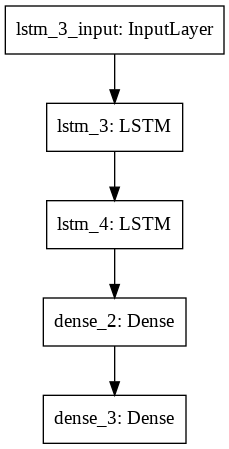

In [0]:
model = create_model()
plot_model(model)

In [0]:
model = create_model()
history = model.fit(train_x, 
                    train_y, 
                    batch_size=400, 
                    epochs=80, 
                    class_weight=class_weights,
                    validation_data=(validation_x, validation_y)
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 33)          8844      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82944     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1419      
Total params: 109,719
Trainable params: 109,719
Non-trainable params: 0
_________________________________________________________________
None
Train on 51088 samples, validate on 6798 samples
Epoch 1/80
51088/51088 [==============================] - 31s 600us/step - loss: 4068.9724 - accuracy: 0.4859 - val_loss: 1.7023 - val_accuracy: 0.5432
Epoch 2/80
51088/51088 [================

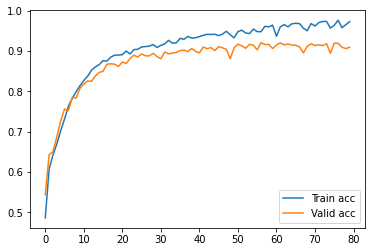

In [0]:
plot_accuracy(history)

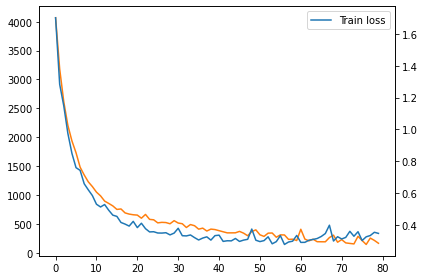

In [0]:
plot_loss(history)

In [0]:
model = create_model2()
history = model.fit(train_x, 
                    train_y, 
                    batch_size=400, 
                    epochs=50, 
                    class_weight=class_weights,
                    validation_data=(validation_x, validation_y)
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 33)          8844      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          25088     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 150,679
Trainable params: 150,679
Non-trainable params: 0
_________________________________________________________________
None
Train on 51088 samples, validate on 6798 samples
Epoch 1/50
51088/51088 [==============================] - 44